# Assignment 3: Ensemble Learning Techniques

## General notes and questions

### Bagging and pasting
The errors of classifiers should be uncorrelated, and one way to ensure this is to train the classifiers on different subsets of data. The `bootstrap` parameter indicates whether bagging or pasting is used.
* *Bagging* samples with replacement (so some classifiers might get the same example) (`bootstrap=True`)
* *Pasting* samples without replacement (so each classifier gets unique examples, `bootstrap=False`)

**Question 1.** The *statistical mode* corresponds to the hard voting strategy where the most frequent prediction is chosed independent of each predictor's confidence.

**Question 2.** Since `DecisionTreeClassifier` has the `predict_proba()` method, `BaggingClassifier` will automatically perform the soft voting with weighted probabilities.

### Out-of-bag evaluation
Due to the nature of random sampling with replacement, it is possible that some instances will be sampled several times and others would not be sampled at all. The ratio approaches $1-\exp(-1)$, so that around $37\%$ are *out-of-bag* instances, which can be used as test data.

### Random forests
* ensembles of decision trees with bagging
* roughly equivalent to `BaggingClassifier` with `DecisionTreeClassifier` as base
* introduces extra randomness compared to bagging classifier + decision trees by looking for a best feature in a random subset of features rather than considering all features at once
    * intuitively adds robustness and diversity in decision trees/predictions
    
### Feature importance
* rank features based on how much they reduce the impurity of all nodes on average across all the decision trees

**Question 3.** The feature importances of the `iris` dataset suggest that the petal length and width are more important features that discriminate the examples the best. This corresponds to the previous practical where petal length and width could linearly separate the species better than sepal length and width. The `digits` plot shows which pixels were the most important in discriminating the digit examples. It makes sense that the left and right edges where no digits are written are not important and the important pixels are next to the centre (especially those which are generally filled for some numbers but not others). For example, the center pixel might be important because it distinguishes 0 quite well (hole in the middle).

### AdaBoost
* The improvement on how classifiers are combined in that the subsequent classifier is more focused on the *errors* on the previous classifiers than the correct ones (but is trained on all of them)
* This makes each classifier in the sequence make different types of errors which in the end should cancel each other out. 
* (**Question 4.**) On the other hand, this slows down the performance as the weights cannot be computed in parallel (they depend on the classifier's performance).
* SAMME (stagewise additive modelling with multiclass exponential loss) is another strategy improvement which makes use of class probabilities as well as predictions (when `predict_proba` is available)


### Gradient boosting
* Difference from AdaBoost is that the classifier is trained on *residual errors* only (not on the full instance).
* **Question 5.** `learning_rate` tells how much to shrink each subsequent estimator's contribution by. If each estimator's contribution is small, we use more estimators; if each estimator contributes by a lot, less estimators are used. On the plots comparing the number of estimators, we can see that with lower learning rate the steps in the red decision boundary are much smaller than when the learning rate is high.

### Gradient boosting with early stopping
* Important not to overfit by running too many estimators and having a less generalisable boundary.
* This is done by stopping training as soon as validation set reaches threshold accuracy.

## Applying the techniques to the `digits` dataset

In [2]:
import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
from sklearn import datasets
digits = datasets.load_digits()
X, y = digits["data"], digits["target"]

Train and test split

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
split.get_n_splits(X, y)

for train_index, test_index in split.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Voting classifier

In [7]:
from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=42, solver='warn',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                             

In [8]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9472222222222222
RandomForestClassifier 0.9638888888888889
SVC 0.6027777777777777
VotingClassifier 0.9583333333333334


Comparing to the baseline as in previous practical—the baseline is just guessing a random digit.

In [18]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class NotXClassifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.random.randint(low=0, high=11, size=(len(X), 1))

not_digit_clf = NotXClassifier()
not_digit_clf_scores = []
for i in digits.target_names:
  score = cross_val_score(not_digit_clf, X_train, y_train, cv=5, scoring="accuracy")
  not_digit_clf_scores.append(score)

print(np.mean(not_digit_clf_scores))

0.09297836817653891


Compared to the 10% accuracy baseline, the final performance of `VotingClassifier` is pretty good, although most of the contribution seems to be from the `RandomForestClassifier` and `LogisticRegression`.

In [26]:
alt_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf)],
    voting='hard')
alt_voting_clf.fit(X_train, y_train)

for clf in (log_clf, rnd_clf, alt_voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9472222222222222
RandomForestClassifier 0.8861111111111111
VotingClassifier 0.9333333333333333


On the other hand, since the overall performance dropped without the SVM, it was probably useful in some ways.

## Bagging and pasting

I am going to use random forests directly as they are equivalent to the `BaggingClassifier` with `DecisionTreeClassifier` base.

In [31]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, 
                                 n_jobs=-1, random_state=42, oob_score=True)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                       warm_start=False)

In [32]:
from sklearn.metrics import accuracy_score
y_pred = rnd_clf.predict(X_test)
print('accuracy {}'.format(accuracy_score(y_test, y_pred)))
print('oob score {}'.format(rnd_clf.oob_score_))

accuracy 0.8861111111111111
oob score 0.9206680584551148


This performs worse than the voting classifiers above. With additional out-of-bag evaluation, it seems that it *generalises quite well* though.

## AdaBoost

In [38]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort=False,
                                                         random_state=None,
                             

Plotting feature importances for the AdaBoost classifier:

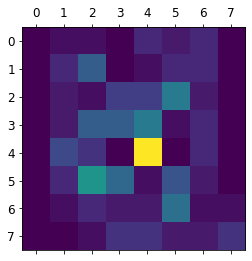

In [46]:
plt.matshow(ada_clf.feature_importances_.reshape((8,8)))

In [47]:
y_pred = ada_clf.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.8111111111111111


Compared to the voting and bagging classifiers, the boosted classifier performs worse.

## Gradient boosting

Applying the three classifiers in the same way as in the practical 3 notebook:

In [75]:
from sklearn.tree import DecisionTreeClassifier

tree_reg1 = DecisionTreeClassifier(max_depth=20, random_state=42)
tree_reg1.fit(X_train, y_train)

y2 = y_train - tree_reg1.predict(X_train)
tree_reg2 = DecisionTreeClassifier(max_depth=20, random_state=42)
tree_reg2.fit(X_train, y2)

y3 = y2 - tree_reg2.predict(X_train)
tree_reg3 = DecisionTreeClassifier(max_depth=20, random_state=42)
tree_reg3.fit(X_train, y3)

y_pred = sum(tree.predict(X_test) for tree in (tree_reg1, tree_reg2, tree_reg3))
print(accuracy_score(y_pred, y_test.astype('float32')))

0.8361111111111111


In [95]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingClassifier(max_depth=10, n_estimators=100, learning_rate=0.1, random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [96]:
print(accuracy_score(gbrt.predict(X_test), y_test))
print(mean_squared_error(gbrt.predict(X_test), y_test))

0.8861111111111111
1.9194444444444445


### Gradient boosting with early stopping

In [93]:
gbrt_es = GradientBoostingClassifier(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt_es.n_estimators = n_estimators
    gbrt_es.fit(X_train, y_train)
    y_pred = gbrt_es.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

print(gbrt_es.n_estimators)

36


In [94]:
print(accuracy_score(gbrt_es.predict(X_test), y_test))

0.9194444444444444
